In [1]:
# import pandas as pd
# from pyspark.sql.functions import col, explode
# from pyspark import SparkContext
# # Import the required functions
# from pyspark.ml.evaluation import RegressionEvaluator
# # from pyspark.ml.recommendation import ALS
# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# from pyspark.ml.feature import * #CountVectorizer,StringIndexer, RegexTokenizer,StopWordsRemover
# from pyspark.sql.functions import * #col, udf,regexp_replace,isnull
# from pyspark.sql.types import * #StringType,IntegerType
# from pyspark.ml.classification import *
# from pyspark.ml.evaluation import *
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# # For pipeline development
# from pyspark.ml import Pipeline 
# from pyspark import SparkContext, SparkConf
# from pyspark.sql import HiveContext, Row
# from pyspark.sql.types import IntegerType
# # import json
# import sys

# 🔝 I already commments out all unneeded spark import

from pyspark import SparkContext, SparkConf
from pyspark.sql import HiveContext, Row
from pyspark.sql.types import IntegerType
import json
import sys
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

inputFile = 'mydata/my_wheather_data.csv'
# inputFile = 'mydata/sample.csv'

conf = SparkConf().setAppName("SparkSQLAirTransit")
SparkConf().set("spark.sql.legacy.timeParserPolicy","LEGACY")

sc = SparkContext.getOrCreate(conf=conf)
hiveCtx = HiveContext(sc)
print("Loading data from " + inputFile)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/02 09:43:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Loading data from mydata/my_wheather_data.csv


/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/context.py:718: FutureWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  warnings.warn(
/Users/abel/Envs/samaritan0/lib/python3.9/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
df = hiveCtx.read.option("header",True).csv(inputFile,inferSchema =True)
df.printSchema()

root
 |-- barometric_value: integer (nullable = true)
 |-- humidity: integer (nullable = true)
 |-- ultraviolet_rays: integer (nullable = true)
 |-- average_quality: integer (nullable = true)
 |-- ozone_relative: integer (nullable = true)
 |-- record_id: integer (nullable = true)
 |-- pm1: integer (nullable = true)
 |-- pm2: integer (nullable = true)
 |-- pm3: integer (nullable = true)
 |-- pm4: integer (nullable = true)



In [3]:
type(df)

pyspark.sql.dataframe.DataFrame

In [4]:
print('View the data sample and search for data')
pd.DataFrame(df.take(10), columns=df.columns).transpose()

View the data sample and search for data


,0,1,2,3,4,5,6,7,8,9
barometric_value,75,72,69,62,66,93,92,79,85,64
humidity,19,10,13,10,12,28,31,17,19,11
ultraviolet_rays,0,0,0,1,1,0,1,1,1,0
average_quality,0,1,0,0,1,1,1,1,1,1
ozone_relative,1,1,0,1,0,0,1,1,1,1
record_id,2,3,4,5,6,7,8,9,10,11
pm1,0,1,0,1,0,1,0,1,0,1
pm2,0,1,0,1,0,1,1,1,0,0
pm3,1,0,1,0,0,1,0,0,1,0
pm4,0,0,1,0,1,1,1,1,1,1


# data explore and feature enginnering

'''
Our dataset is a selection of columns from open source datasets for data exploration and analysis
More detailed column description can find clues from the following url：

https://archive.ics.uci.edu/ml/datasets/heart+Disease

This full database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to
this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).

The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.

One file has been "processed", that one containing the Cleveland database. All four unprocessed files also exist in this directory.

To see Test Costs (donated by Peter Turney), please see the folder "Costs"
'''

In [5]:
mypd = pd.read_csv(inputFile)


# duplicate data check
mypd.drop(['humidity'], axis  = 1).duplicated().sum()

0

In [6]:
mypd.nunique()

barometric_value         41
humidity                 24
ultraviolet_rays          2
average_quality           2
ozone_relative            2
record_id           4000000
pm1                       2
pm2                       2
pm3                       2
pm4                       2
dtype: int64

In [7]:
mypd.isnull().sum()


barometric_value    0
humidity            0
ultraviolet_rays    0
average_quality     0
ozone_relative      0
record_id           0
pm1                 0
pm2                 0
pm3                 0
pm4                 0
dtype: int64

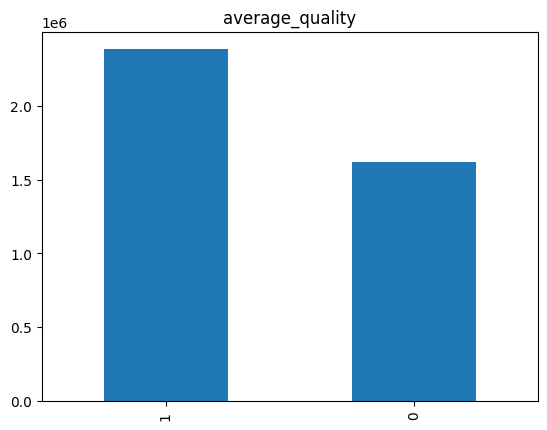

In [9]:
_ = mypd["average_quality"].value_counts().plot(kind = 'bar', title = 'average_quality')

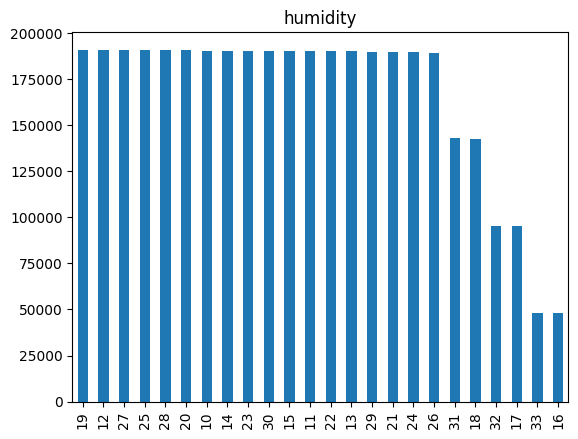

In [10]:
_ = mypd["humidity"].value_counts().plot(kind = 'bar', title = 'humidity')

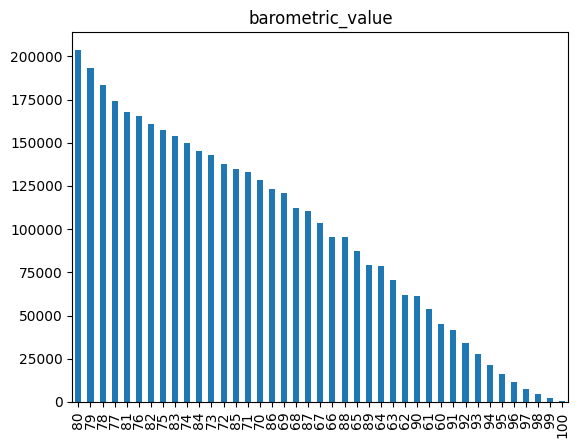

In [11]:
_ = mypd["barometric_value"].value_counts().plot(kind = 'bar', title = 'barometric_value')

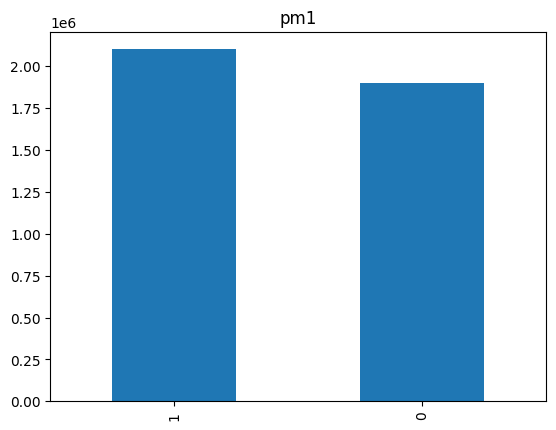

In [12]:
_ = mypd["pm1"].value_counts().plot(kind = 'bar', title = 'pm1')

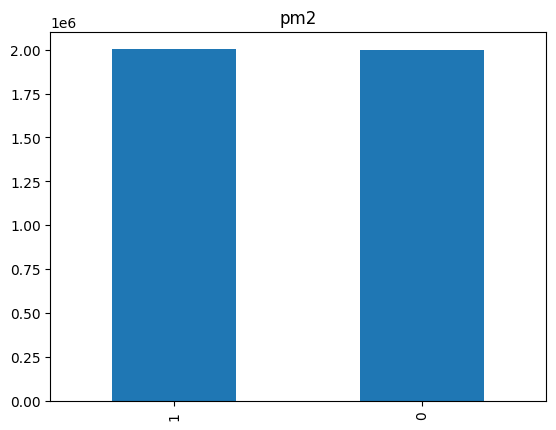

In [13]:
_ = mypd["pm2"].value_counts().plot(kind = 'bar', title = 'pm2')

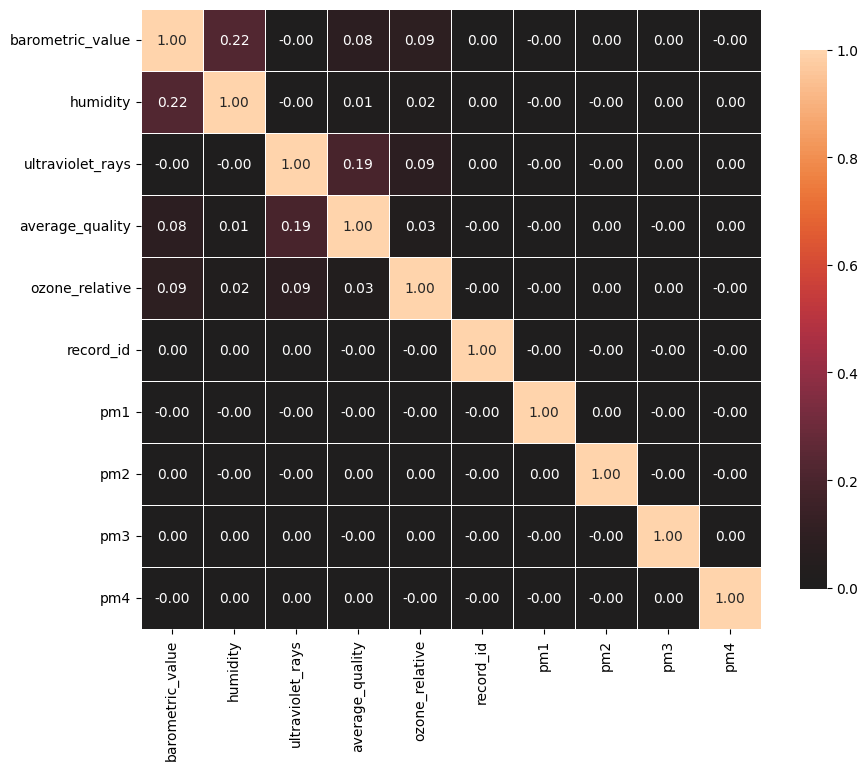

In [14]:


def correlation_heatmap(train): 
    correlations = train.corr()
    fig, ax = plt.subplots(figsize=(10,10))    
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',         
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})    
    plt.show();
correlation_heatmap(mypd)

'''
Computing the correlation between two series of data is a common operation in statistics. Many algorithms are provided in spark.ml to calculate pairwise correlations. The currently supported correlation algorithms are Pearson and Spearman. Correlation computes the correlation matrix for the input dataset using the specified method. The output is a DataFrame containing a correlation matrix of vector columns
'''

affinity analysis ----------------------------------------


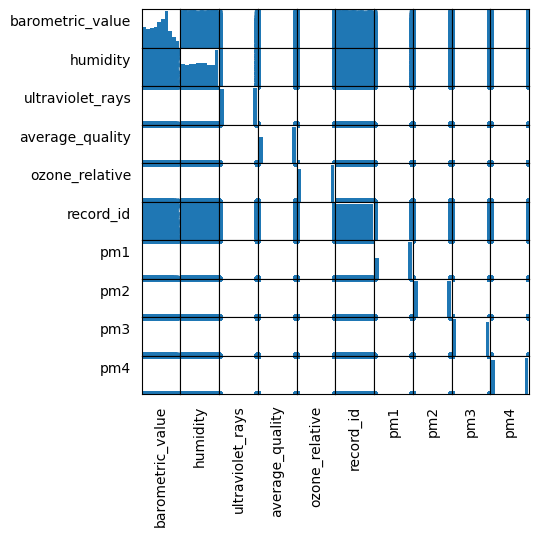

In [15]:
df = hiveCtx.read.option("header",True).csv('mydata/sample.csv',inferSchema =True)

numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

print('affinity analysis', '-'*40)
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(5, 5));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

# analyis and feature enginering , choose my columns (target and feature column) to anlyis
'''
high-dimensional datasets. In this case, it is better to visualize the correlation in a matrix. 
Here's how to achieve this using a visualization, I'm using our full Dataset ss you can see from the matrix above, 
there is a high correlation between heart disease 
and the first four variables, as well as between alcohol consumption and body fat percentage.
This is also in line with our daily common sense: 
there is no randomness in the patient's community id (patientid), 
and gender may not necessarily be related to heart disease or diabetes, 
or if there is, it is not directly related; whether to take painkillers, 
It has little to do with the pain area and whether you have a heart attack,
because it is something that has already happened, 
and there is no necessary correlation. It is a post-occurrence thing.
'''
# we need to double check which columns are useless
'''
If our dataset has completely positive or negative properties, then the performance of the model is likely to suffer from a problem called "multicollinearity". Multicollinearity occurs when one predictor in a multiple regression model can be linearly predicted by other predictors with high prediction accuracy. This may lead to distorted or misleading results. Fortunately, decision tree and boosted tree algorithms are inherently immune to multicollinearity. When they decide to split, the tree selects only one fully related feature. However, other algorithms like logistic regression or linear regression also do not avoid this problem and you should fix it before training the model

Correlation between variables does not imply causation. Any highly correlated variables should be carefully examined and considered

So we then performed feature analysis on all the data columns, completely random columns, we can treat them as noise columns. We can see that heart disease, diabetes, bmi, drinking or not, and age show great regularity in the data (regularity here refers to non-random, and has certain characteristics of time, distribution, and non-complete randomness)
'''

# what problme we choose to explore?
'''
In fact, this data set can analyze many problems, we choose the most likely problem in data analysis: the correlation between heart disease and other factors. The reason why we give up studying the relationship between diabetes and heart disease, or diabetes and other factors, is because statistical analysis, correlation analysis, and characteristic analysis of each column show the correlation of heart disease bi
'''

In [16]:
cols_to_drop = ['record_id', 'pm1', 'pm2', 'pm3', 'pm4']
df = df.drop(*cols_to_drop)

In [20]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
categoricalColumns = ['barometric_value','humidity','ultraviolet_rays','average_quality']
stages = []
# for categoricalCol in categoricalColumns:
#     stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
#     encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
#     stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'average_quality', outputCol = 'label')
stages += [label_stringIdx]
numericCols = categoricalColumns
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


In [21]:

from pyspark.ml import Pipeline
cols = df.columns
print('cols=', cols, type(cols))

# print('after choosed ,cols=', cols)
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)

cols= ['barometric_value', 'humidity', 'ultraviolet_rays', 'average_quality', 'ozone_relative'] <class 'list'>


In [22]:
print('Data set split')
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Data set split
Training Dataset Count: 3538
Test Dataset Count: 1462


# random forest algorithm
'''
Random forest is an extended variant of bagging,
and after understanding the bagging method, random forest is much easier to learn. 
On the basis of building Bagging ensemble with decision tree as the base learner, 
RF further adds random attribute selection in the training process of decision tree. 
Specifically, the traditional decision tree selects an optimal attribute 
among all the candidate attributes of the current node (assuming there are d)
when selecting the attributes for division; while in RF, for each node of the base decision tree, 
first A subset containing k attributes is randomly selected from the set of candidate attributes of the node, 
and then an optimal attribute is selected from this subset for partitioning. 
The choice of the number of attributes k to be extracted is more important,
and is generally recommended. As a result, the "diversity" of the base learner 
of random forest comes not only from the perturbation of samples, but also from the perturbation of attributes, 
which further enhances the generalization ability of the final ensemble
'''

In [23]:
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import RandomForestClassifier



lr = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
# lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

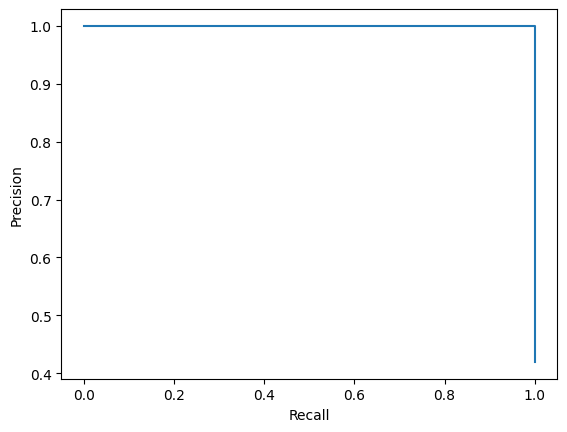

In [24]:
trainingSummary = lrModel.summary
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [25]:
print('Supervised Machine Learning Machine Forest Results：')
predictions = lrModel.transform(test)
predictions.select('barometric_value','humidity','ultraviolet_rays','average_quality', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Supervised Machine Learning Machine Forest Results：
+----------------+--------+----------------+---------------+-----+-------------+----------+-----------+
|barometric_value|humidity|ultraviolet_rays|average_quality|label|rawPrediction|prediction|probability|
+----------------+--------+----------------+---------------+-----+-------------+----------+-----------+
|              60|      10|               0|              1|  0.0|   [20.0,0.0]|       0.0|  [1.0,0.0]|
|              60|      11|               1|              1|  0.0|   [20.0,0.0]|       0.0|  [1.0,0.0]|
|              60|      12|               0|              1|  0.0|   [20.0,0.0]|       0.0|  [1.0,0.0]|
|              60|      12|               0|              1|  0.0|   [20.0,0.0]|       0.0|  [1.0,0.0]|
|              60|      12|               1|              1|  0.0|   [20.0,0.0]|       0.0|  [1.0,0.0]|
|              60|      13|               1|              1|  0.0|   [20.0,0.0]|       0.0|  [1.0,0.0]|
|           

In [26]:
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import RandomForestClassifier
# lr = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

22/12/02 09:44:20 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/12/02 09:44:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/02 09:44:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


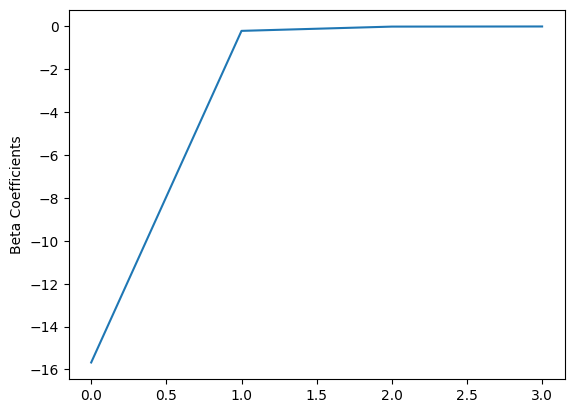

In [27]:
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

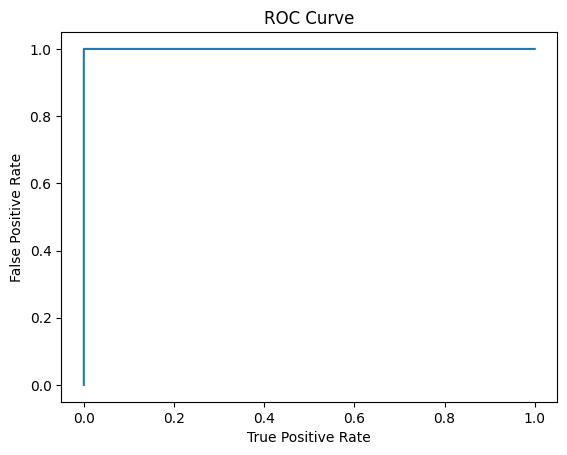

Training set areaUnderROC: 1.0


In [28]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

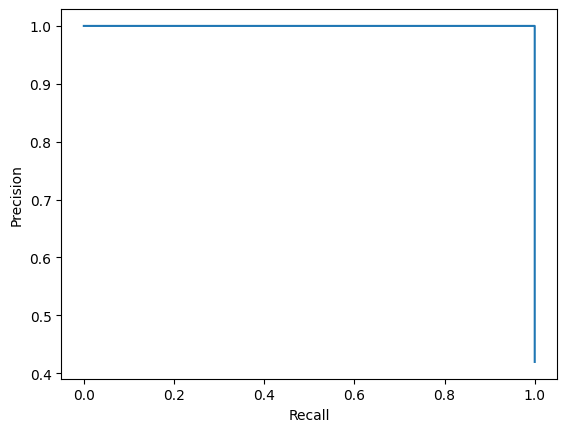

In [29]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [30]:
print('Supervised Machine Learning Logistic Regression Results：')
predictions = lrModel.transform(test)
predictions.select('barometric_value','humidity','ultraviolet_rays','average_quality', 'label', 'rawPrediction', 'prediction', 'probability').show(10)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Supervised Machine Learning Logistic Regression Results：
+----------------+--------+----------------+---------------+-----+--------------------+----------+--------------------+
|barometric_value|humidity|ultraviolet_rays|average_quality|label|       rawPrediction|prediction|         probability|
+----------------+--------+----------------+---------------+-----+--------------------+----------+--------------------+
|              60|      10|               0|              1|  0.0|[7.70748147365473...|       0.0|[0.99955074990673...|
|              60|      11|               1|              1|  0.0|[7.91443104372124...|       0.0|[0.99963470174779...|
|              60|      12|               0|              1|  0.0|[7.70950482689073...|       0.0|[0.99955165757224...|
|              60|      12|               0|              1|  0.0|[7.70950482689073...|       0.0|[0.99955165757224...|
|              60|      12|               1|              1|  0.0|[7.91544272033924...|       0.0|[0.99

In [31]:
print('Unsupervised machine learning kmean')
from pyspark.ml.clustering import KMeans

print('2 cluster experements:')
kmeans = KMeans(k=2, seed=1)  # 2 clusters here
model = kmeans.fit(df.select('features'))

Unsupervised machine learning kmean
2 cluster experements:


In [32]:
transformed = model.transform(df)
transformed.show()    

+-----+-------------------+----------------+--------+----------------+---------------+--------------+----------+
|label|           features|barometric_value|humidity|ultraviolet_rays|average_quality|ozone_relative|prediction|
+-----+-------------------+----------------+--------+----------------+---------------+--------------+----------+
|  1.0|[90.0,13.0,0.0,0.0]|              90|      13|               0|              0|             1|         0|
|  0.0|[67.0,23.0,1.0,1.0]|              67|      23|               1|              1|             0|         1|
|  1.0|[65.0,11.0,1.0,0.0]|              65|      11|               1|              0|             0|         1|
|  1.0|[66.0,29.0,0.0,0.0]|              66|      29|               0|              0|             1|         1|
|  1.0|[69.0,18.0,1.0,0.0]|              69|      18|               1|              0|             0|         1|
|  0.0|[63.0,30.0,0.0,1.0]|              63|      30|               0|              1|          

In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):
    print('Unsupervised classification [k]=', K)
    KMeans_=KMeans(featuresCol='features', k=K)

    KMeans_fit=KMeans_.fit(df.select('features'))

    KMeans_transform=KMeans_fit.transform(df.select('features')) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

Unsupervised classification [k]= 2
Unsupervised classification [k]= 3
Unsupervised classification [k]= 4
Unsupervised classification [k]= 5
Unsupervised classification [k]= 6
Unsupervised classification [k]= 7
Unsupervised classification [k]= 8
Unsupervised classification [k]= 9
Unsupervised classification [k]= 10


Unsupervised classification


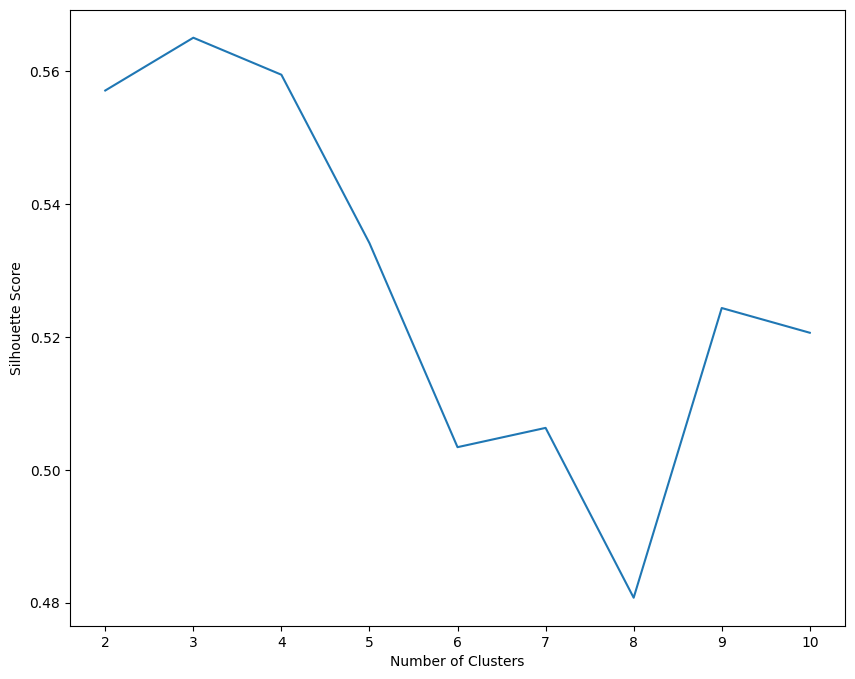

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
print('Unsupervised classification')